In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from hydra.utils import instantiate
from hydra import initialize, compose
import hydra

import wandb

from data.dataManager import DataManager
from model.modelCreator import ModelCreator
from omegaconf import OmegaConf
from scripts.run import setup_model, load_model_instance

from utils.plots import vae_plots
from utils.rbm_plots import plot_rbm_histogram, plot_rbm_params, plot_forward_output_v2

from scripts.run import set_device

[17:26:38.557] INFO   CaloQuVAE                                         Loading configuration.


In [2]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="CaloQuVAE/config")
config=compose(config_name="config.yaml")
wandb.init(tags = [config.data.dataset_name], project=config.wandb.project, entity=config.wandb.entity, config=OmegaConf.to_container(config, resolve=True), mode='disabled')

In [3]:
new_model = False
if new_model:
    self = setup_model(config)
    # self.model = self.model.double()  # sets all model parameters to float64
else:
    self = load_model_instance(config)
    # self.model = self.model.double()


[17:26:47.152] INFO   data.dataManager                                  Loading ATLAS dataset: AtlasReg000New


[17:26:48.855] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f785a29b2c0>: 119999 events, 469 batches
[17:26:48.856] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f77b1a22d80>: 15001 events, 15 batches
[17:26:48.857] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f77b258c170>: 14999 events, 15 batches
[17:26:48.858] INFO   model.modelCreator                                ::Creating Model
[17:26:49.889] WARN   model.rbm.zephyr                                  QPU is offline. Setting a hard-coded zephyr. Check to see you're pinging the correct chip_id


/home/jtoledo


[17:26:50.327] INFO   scripts.run                                       Requesting GPUs. GPU list :[1]
[17:26:50.328] INFO   scripts.run                                       Main GPU : cuda:1
[17:26:50.493] INFO   scripts.run                                       CUDA available


cuda:1


[17:26:51.331] INFO   model.modelCreator                                Loading state
[17:26:51.429] INFO   model.modelCreator                                Loading weights from file : /fast_scratch_1/caloqvae/jtoledo/wandb/run-20250922_210528-bpfg29py/files/autoencoderhidden_229.pth
[17:26:51.608] INFO   model.modelCreator                                Loaded VAE optimizer state


Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _bce_loss
Loading weights for module =  encoder
Loading weights for module =  decoder
Loading weights for module =  prior


In [4]:
self.evaluate_vae(self.data_mgr.val_loader,0)

[17:27:34.810] INFO   engine.engine                                     Epoch: 0 - Average Val Loss: 6358.3016


{'val_ae_loss': 6228.901534016927,
 'val_kl_loss': -191.80175374348957,
 'val_hit_loss': 321.2017384847005,
 'val_entropy': -201.30281880696614,
 'val_pos_energy': -798.1627563476562,
 'val_neg_energy': 807.663818359375,
 'val_logit_distance': 0.0,
 'val_loss': 6358.301578776041}

In [ ]:
print(self.prior_samples.shape)
print(self.post_samples.shape)

post_samples = [self.post_samples[:1000,:302].to(self.device), 
             self.post_samples[:1000,302:604].to(self.device),
            self.post_samples[:1000,604:].to(self.device),
            self.model.logit_mcmc(self.model.prior.weight_dict['03'],self.model.prior.weight_dict['13'],
                      self.model.prior.weight_dict['23'], post_samples[0], post_samples[1], post_samples[2], 
                      self.model.prior.bias_dict['3'])]
prior_samples = [self.prior_samples[:1000,:302].to(self.device), 
             self.prior_samples[:1000,302:604].to(self.device),
            self.prior_samples[:1000,604:906].to(self.device),
            self.prior_samples[:1000,906:].to(self.device)]


torch.Size([14999, 1208])
torch.Size([14999, 906])


In [82]:
def enLand(x,y,a,b,l,idx):
    return -x*a[idx]-y*b[idx]-l[idx]*x*y

F01 = torch.linalg.svd(self.model.prior.weight_dict['01'].detach())
a01 = F01[0].T @ self.model.prior.bias_dict['0'].detach()
b01 = F01[2] @ self.model.prior.bias_dict['1'].detach()
l01 = F01[1].detach()
u01 = F01[0].T @ prior_samples[0].T
w01 = F01[2] @ prior_samples[1].T
u01_post = F01[0].T @ post_samples[0].T
w01_post = F01[2] @ post_samples[1].T

F02 = torch.linalg.svd(self.model.prior.weight_dict['02'].detach())
a02 = F02[0].T @ self.model.prior.bias_dict['0'].detach()
b02 = F02[2] @ self.model.prior.bias_dict['2'].detach()
l02 = F02[1].detach()
u02 = F02[0].T @ prior_samples[0].T
w02 = F02[2] @ prior_samples[2].T
u02_post = F02[0].T @ post_samples[0].T
w02_post = F02[2] @ post_samples[2].T

F03 = torch.linalg.svd(self.model.prior.weight_dict['03'].detach())
a03 = F03[0].T @ self.model.prior.bias_dict['0'].detach()
b03 = F03[2] @ self.model.prior.bias_dict['3'].detach()
l03 = F03[1].detach()
u03 = F03[0].T @ prior_samples[0].T
w03 = F03[2] @ prior_samples[3].T
u03_post = F03[0].T @ post_samples[0].T
w03_post = F03[2] @ post_samples[3].T

F12 = torch.linalg.svd(self.model.prior.weight_dict['12'].detach())
a12 = F12[0].T @ self.model.prior.bias_dict['1'].detach()
b12 = F12[2] @ self.model.prior.bias_dict['2'].detach()
l12 = F12[1].detach()
u12 = F12[0].T @ prior_samples[1].T
w12 = F12[2] @ prior_samples[2].T
u12_post = F12[0].T @ post_samples[1].T
w12_post = F12[2] @ post_samples[2].T

F13 = torch.linalg.svd(self.model.prior.weight_dict['13'].detach())
a13 = F13[0].T @ self.model.prior.bias_dict['1'].detach()
b13 = F13[2] @ self.model.prior.bias_dict['3'].detach()
l13 = F13[1].detach()
u13 = F13[0].T @ prior_samples[1].T
w13 = F13[2] @ prior_samples[3].T
u13_post = F13[0].T @ post_samples[1].T
w13_post = F13[2] @ post_samples[3].T

F23 = torch.linalg.svd(self.model.prior.weight_dict['23'].detach())
a23 = F23[0].T @ self.model.prior.bias_dict['2'].detach()
b23 = F23[2] @ self.model.prior.bias_dict['3'].detach()
l23 = F23[1].detach()
u23 = F23[0].T @ prior_samples[2].T
w23 = F23[2] @ prior_samples[3].T
u23_post = F23[0].T @ post_samples[2].T
w23_post = F23[2] @ post_samples[3].T

Text(0.5, 1.0, '23 Layer')

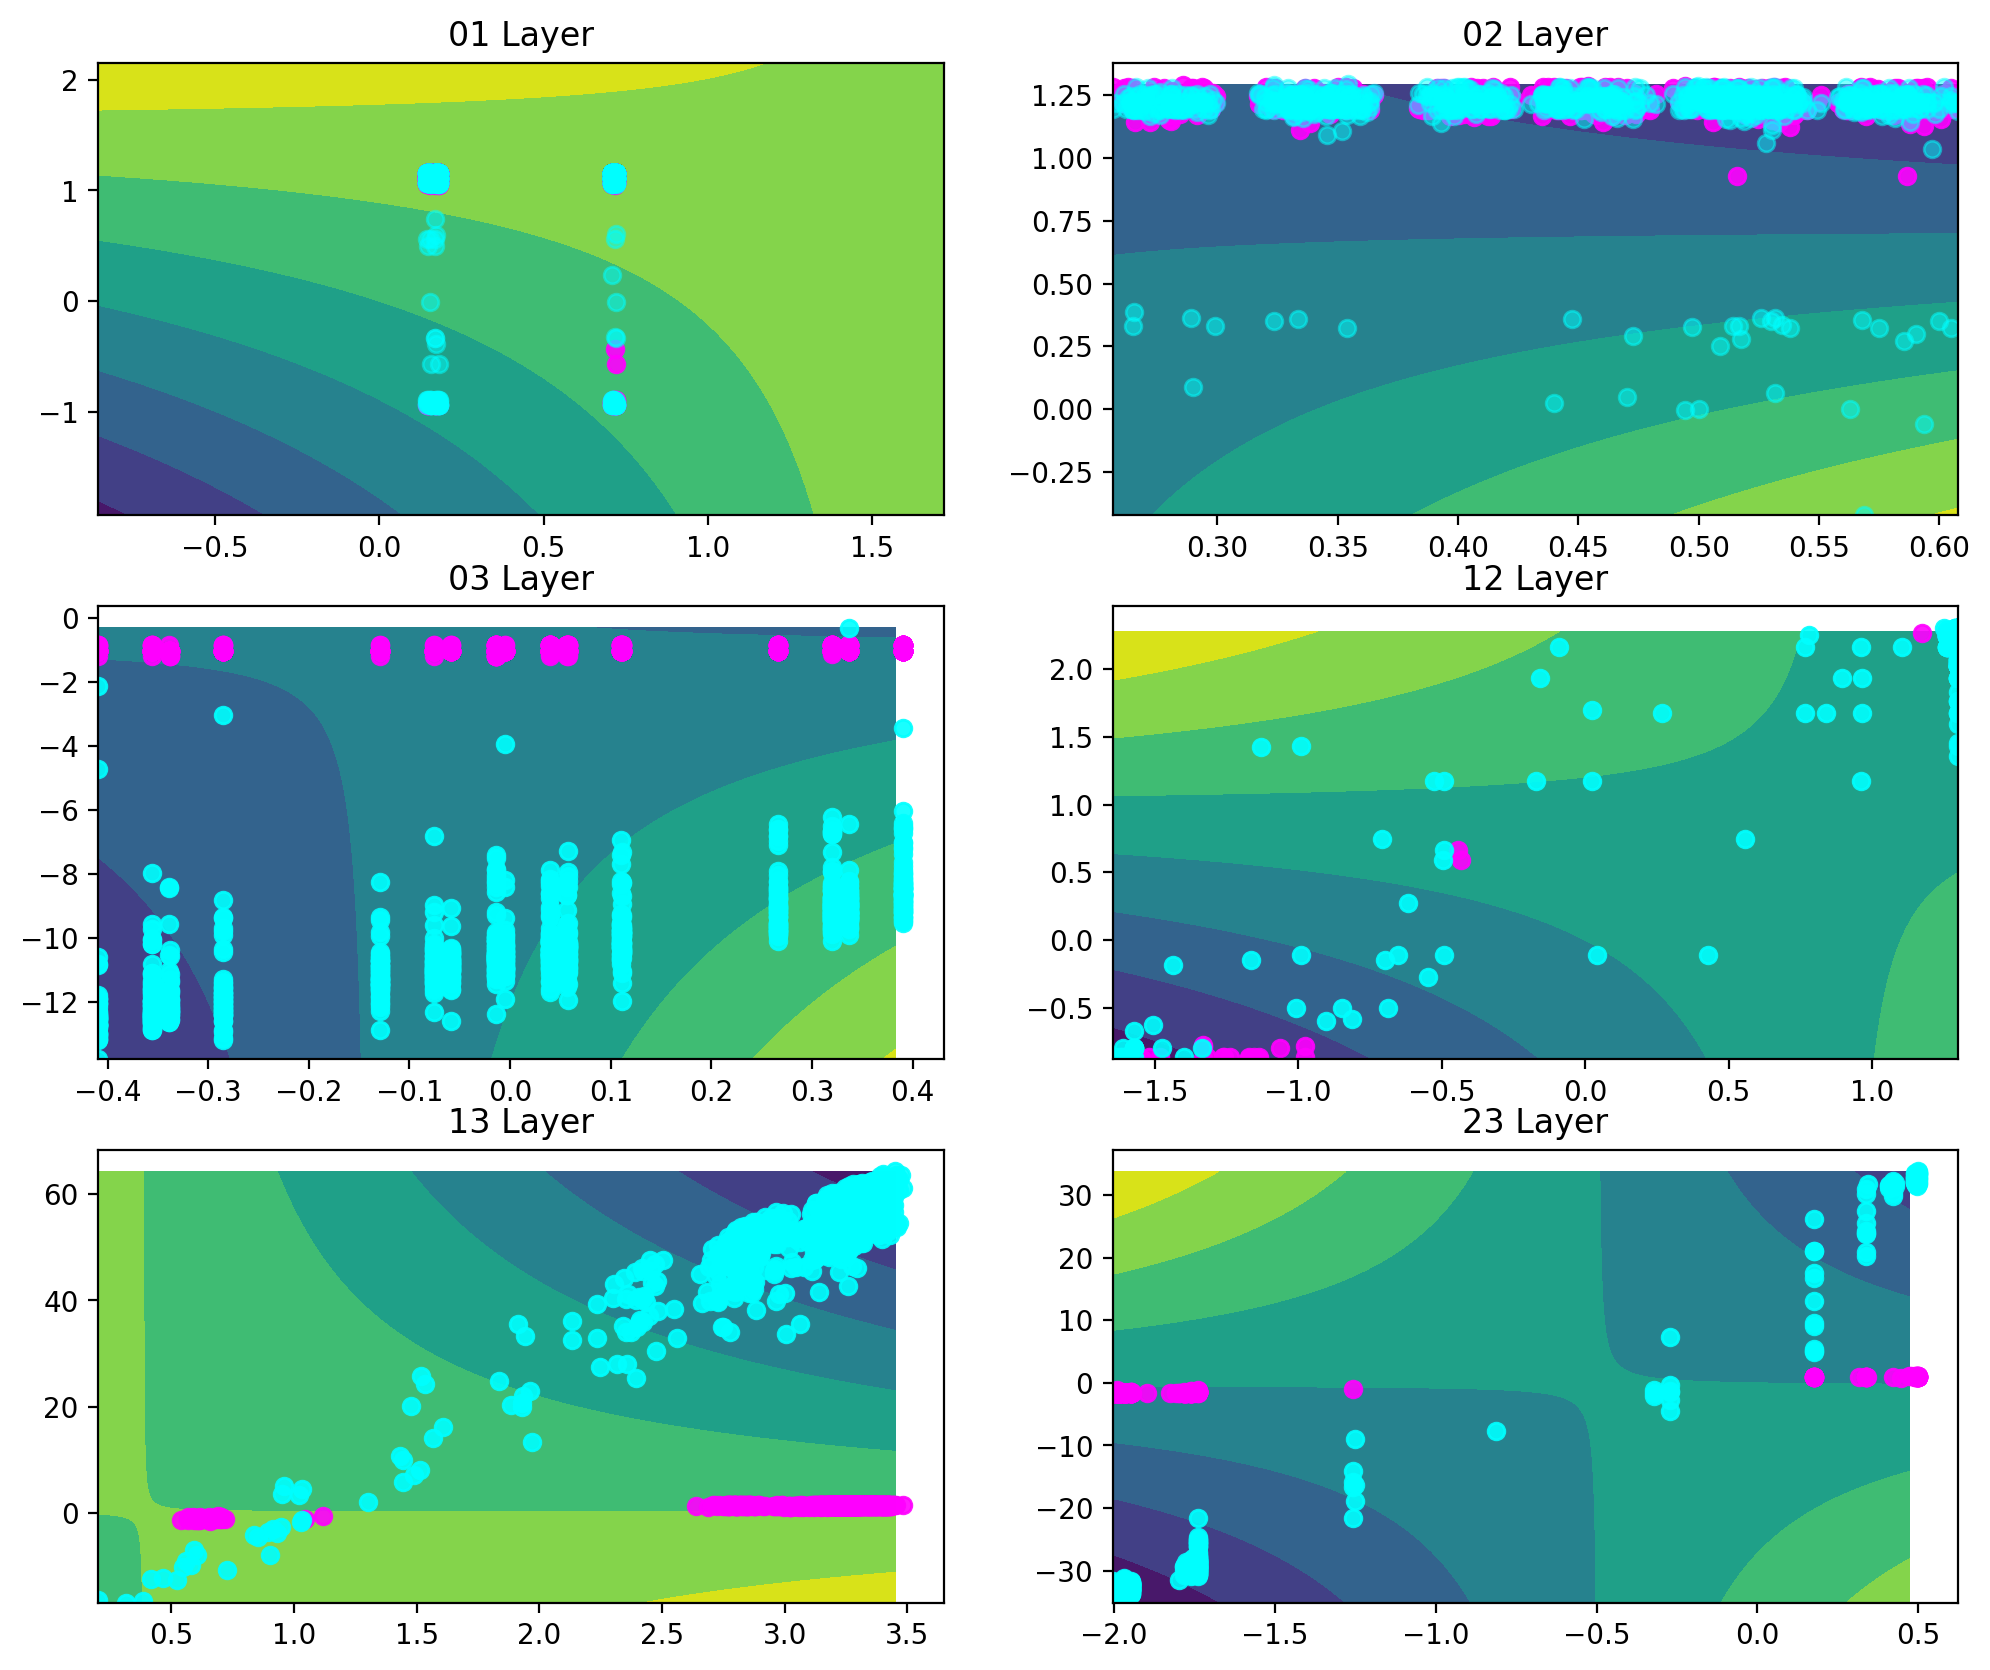

In [88]:
idx=0
fig, ax = plt.subplots(3,2, figsize=(12,10))

xmin = torch.min(torch.tensor([u01_post[idx,:].min(),u01[idx,:].min()]))
xmax = torch.max(torch.tensor([u01_post[idx,:].max(),u01[idx,:].max()]))
ymin = torch.min(torch.tensor([w01_post[idx,:].min(),w01[idx,:].min()]))
ymax = torch.max(torch.tensor([w01_post[idx,:].max(),w01[idx,:].max()]))
delta = min((xmax - xmin)/100., (ymax - ymin)/100.)
x = torch.arange(xmin-1, xmax+1, delta)
y = torch.arange(ymin-1, ymax+1, delta)
X, Y = torch.meshgrid(x, y)
Z = enLand(X, Y, a01.cpu(), b01.cpu(), l01.cpu(), idx)
CS = ax[0, 0].contourf(X, Y, Z)
ax[0, 0].scatter(u01[idx,:].cpu(), w01[idx,:].cpu(), alpha=0.9, c='magenta')
ax[0, 0].scatter(u01_post[idx,:].cpu(), w01_post[idx,:].cpu(), alpha=0.5, c='cyan')
ax[0, 0].set_title('01 Layer')

xmin = torch.min(torch.tensor([u02_post[idx,:].min(),u02[idx,:].min()]))
xmax = torch.max(torch.tensor([u02_post[idx,:].max(),u02[idx,:].max()]))
ymin = torch.min(torch.tensor([w02_post[idx,:].min(),w02[idx,:].min()]))
ymax = torch.max(torch.tensor([w02_post[idx,:].max(),w02[idx,:].max()]))
delta = min((xmax - xmin)/100., (ymax - ymin)/100.)
x = torch.arange(xmin, xmax, delta)
y = torch.arange(ymin, ymax, delta)
X, Y = torch.meshgrid(x, y)
Z = enLand(X, Y, a02.cpu(), b02.cpu(), l02.cpu(), idx)
CS = ax[0, 1].contourf(X, Y, Z)
ax[0, 1].scatter(u02[idx,:].cpu(), w02[idx,:].cpu(), alpha=0.9, c='magenta')
ax[0, 1].scatter(u02_post[idx,:].cpu(), w02_post[idx,:].cpu(), alpha=0.5, c='cyan')
ax[0, 1].set_title('02 Layer')

xmin = torch.min(torch.tensor([u03_post[idx,:].min(),u03[idx,:].min()]))
xmax = torch.max(torch.tensor([u03_post[idx,:].max(),u03[idx,:].max()]))
ymin = torch.min(torch.tensor([w03_post[idx,:].min(),w03[idx,:].min()]))
ymax = torch.max(torch.tensor([w03_post[idx,:].max(),w03[idx,:].max()]))
delta = min((xmax - xmin)/100., (ymax - ymin)/100.)
x = torch.arange(xmin, xmax, delta)
y = torch.arange(ymin, ymax, delta)
X, Y = torch.meshgrid(x, y)
Z = enLand(X, Y, a03.cpu(), b03.cpu(), l03.cpu(), idx)
CS = ax[1, 0].contourf(X, Y, Z)
ax[1, 0].scatter(u03[idx,:].cpu(), w03[idx,:].cpu(), alpha=0.9, c='magenta')
ax[1, 0].scatter(u03_post[idx,:].cpu(), w03_post[idx,:].cpu(), alpha=0.9, c='cyan')
ax[1, 0].set_title('03 Layer')

xmin = torch.min(torch.tensor([u12_post[idx,:].min(),u12[idx,:].min()]))
xmax = torch.max(torch.tensor([u12_post[idx,:].max(),u12[idx,:].max()]))
ymin = torch.min(torch.tensor([w12_post[idx,:].min(),w12[idx,:].min()]))
ymax = torch.max(torch.tensor([w12_post[idx,:].max(),w12[idx,:].max()]))
delta = min((xmax - xmin)/100., (ymax - ymin)/100.)
x = torch.arange(xmin, xmax, delta)
y = torch.arange(ymin, ymax, delta)
X, Y = torch.meshgrid(x, y)
Z = enLand(X, Y, a12.cpu(), b12.cpu(), l12.cpu(), idx)
CS = ax[1, 1].contourf(X, Y, Z)
ax[1, 1].scatter(u12[idx,:].cpu(), w12[idx,:].cpu(), alpha=0.9, c='magenta')
ax[1, 1].scatter(u12_post[idx,:].cpu(), w12_post[idx,:].cpu(), alpha=0.9, c='cyan')
ax[1, 1].set_title('12 Layer')

xmin = torch.min(torch.tensor([u13_post[idx,:].min(),u13[idx,:].min()]))
xmax = torch.max(torch.tensor([u13_post[idx,:].max(),u13[idx,:].max()]))
ymin = torch.min(torch.tensor([w13_post[idx,:].min(),w13[idx,:].min()]))
ymax = torch.max(torch.tensor([w13_post[idx,:].max(),w13[idx,:].max()]))
delta = min((xmax - xmin)/100., (ymax - ymin)/100.)
x = torch.arange(xmin, xmax, delta)
y = torch.arange(ymin, ymax, delta)
X, Y = torch.meshgrid(x, y)
Z = enLand(X, Y, a13.cpu(), b13.cpu(), l13.cpu(), idx)
CS = ax[2, 0].contourf(X, Y, Z)
ax[2, 0].scatter(u13[idx,:].cpu(), w13[idx,:].cpu(), alpha=0.9, c='magenta')
ax[2, 0].scatter(u13_post[idx,:].cpu(), w13_post[idx,:].cpu(), alpha=0.9, c='cyan')
ax[2, 0].set_title('13 Layer')

xmin = torch.min(torch.tensor([u23_post[idx,:].min(),u23[idx,:].min()]))
xmax = torch.max(torch.tensor([u23_post[idx,:].max(),u23[idx,:].max()]))
ymin = torch.min(torch.tensor([w23_post[idx,:].min(),w23[idx,:].min()]))
ymax = torch.max(torch.tensor([w23_post[idx,:].max(),w23[idx,:].max()]))
delta = min((xmax - xmin)/100., (ymax - ymin)/100.)
x = torch.arange(xmin, xmax, delta)
y = torch.arange(ymin, ymax, delta)
X, Y = torch.meshgrid(x, y)
Z = enLand(X, Y, a23.cpu(), b23.cpu(), l23.cpu(), idx)
CS = ax[2, 1].contourf(X, Y, Z)
ax[2, 1].scatter(u23[idx,:].cpu(), w23[idx,:].cpu(), alpha=0.9, c='magenta')
ax[2, 1].scatter(u23_post[idx,:].cpu(), w23_post[idx,:].cpu(), alpha=0.9, c='cyan')
ax[2, 1].set_title('23 Layer')